## CrowdED: Crowdsourcing task optimization
---
The research question we aim to answer is: "Can we a-priori estimate optimal workers and tasks' assignment to obtain maximum accuracy on all tasks?"

*This notebook takes step by step the construction of the crowdED module*

In [17]:
import sys
import pandas as pd
import numpy as np
import shortuuid as uid
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

---
### Data preparation: Tasks and Workers Dataframe Construction

I want to model the workers

In [1]:
total_tasks = 342

In [2]:
total_workers = 50

In [3]:
#Tasks variables
p_hard_tasks = 0.2
n_hard_tasks = int(round(p_hard_tasks*total_tasks,0))

p_easy_tasks = 1-p_hard_tasks 
n_easy_tasks = int(round(p_easy_tasks*total_tasks,0))

In [4]:
print(n_hard_tasks, n_easy_tasks)

68 274


Next, we randomly assign (without [replacement](https://www.ma.utexas.edu/users/parker/sampling/repl.htm)) which tasks and workers are easy/hard and good/poor based on the proportions specified.

#### Workers

In [12]:
workers = [uid.ShortUUID().random(length=5) for i in range(total_workers)]

In [13]:
df_workers = pd.DataFrame()
df_workers['worker_id'] = workers

In [16]:
df_workers.head()

,worker_id
0,Wppj5
1,LXEWi
2,tup9j
3,pU2Ln
4,GLmgP


#### Tasks 

In [17]:
tasks = ['task_'+uid.ShortUUID().random(length=3) for i in range(total_tasks)]
easy_tasks = [task for task in np.random.choice(tasks, n_easy_tasks, replace=False)]
hard_tasks = [task for task in set(tasks)-set(easy_tasks)]

#### True Answers (Gold)

In our simulation, the task is that the worker has to choose one out of the five given answers. Here, we simulate the true answer for each worker-task pair.

In [25]:
#answers_key = ["liver", "blood", "lung", "brain", "heart"]
from random_words import RandomWords
rw = RandomWords()
answers_key = rw.random_words(count=5)

In [26]:
answers_key

['hoods', 'administrators', 'score', 'sixties', 'bands']

In [27]:
true_answers = [answer for answer in np.random.choice(answers_key, total_tasks)]

In [29]:
# Creating the tasks data frame
df_tasks = pd.DataFrame()
df_tasks['task_id'] = tasks
df_tasks['true_answers'] = true_answers

In [30]:
df_tasks['label_task'] = ['hard_task' if tasks[i] in hard_tasks else 'easy_task' for i in range(total_tasks)]

In [64]:
df_tasks.head()

,task_id,true_answers,label_task
0,task_uEe,bands,easy_task
1,task_PN4,hoods,easy_task
2,task_zAr,hoods,hard_task
3,task_fEv,sixties,easy_task
4,task_x8M,administrators,easy_task


---
### Probabilities of getting the answer right
In this step, we first calculate the exact probabilities of getting the answer right for each worker and each task.

#### Las respuestas de los workers se distribuye bernoulli con parametro beta

#### Los experimentos de Amrapali van a ayudar a estimar los parámetros de la beta  

https://www.figure-eight.com/dataset/medical-sentence-summary-and-relation-extraction/

https://aaai.org/ocs/index.php/HCOMP/HCOMP16/paper/viewFile/14047/13632  

Here a ∈ (0, 1) is the normalized value of the average ability of the workers in the crowdsourcing platform.  
v ∈ (0, 1) is a parameter that determines the variance in worker ability  

Distributions:  
    
http://cmdlinetips.com/2018/03/probability-distributions-in-python/
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html
https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.beta.html

/Users/pedrohserrano/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


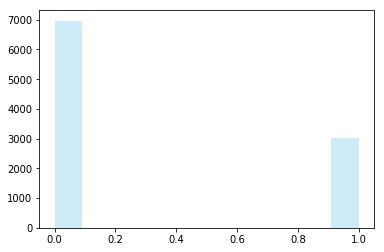

In [50]:
#this only to show bernoulli distribution
from scipy.stats import bernoulli
data_bern = bernoulli.rvs(size=10000,p=0.3)
sns.distplot(data_bern, kde=False, color="skyblue")

In [41]:
data_bern

array([0, 1, 1, ..., 1, 0, 0])

/Users/pedrohserrano/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


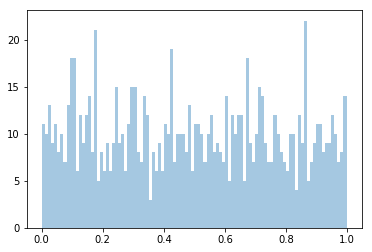

In [44]:
from scipy.stats import beta
data_beta = beta.rvs(1, 1, size=10000)
sns.distplot(data_beta, kde=False, bins=100)

In [59]:
#vec_bernoullies

In [61]:
#WORKERS PROB
data_beta

array([0.96745223, 0.95124558, 0.91148532, 0.99139771, 0.75334404,
       0.87228749, 0.9593587 , 0.96925603, 0.99646804, 0.84025713,
       0.89024794, 0.64199361, 0.99103444, 0.95549076, 0.99181039,
       0.81963639, 0.98039895, 0.87719701, 0.80609951, 0.62515772,
       0.81374682, 0.69739335, 0.83136117, 0.82903904, 0.67175824,
       0.82967192, 0.96829701, 0.81340338, 0.95285518, 0.73405952,
       0.95002015, 0.74226516, 0.82056281, 0.85542975, 0.84075854,
       0.80930143, 0.82403341, 0.56564657, 0.78438153, 0.8977388 ,
       0.87118501, 0.75694603, 0.83781101, 0.95520331, 0.980902  ,
       0.95026684, 0.99195459, 0.74754476, 0.78085038, 0.89890409])

In [69]:
df_workers['prob_worker'] = data_beta #probs_workers

In [77]:
df_workers.head()

,worker_id,prob_worker
0,Wppj5,0.967452
1,LXEWi,0.951246
2,tup9j,0.911485
3,pU2Ln,0.991398
4,GLmgP,0.753344


In [71]:
#Is tasks distribution normal? constant?

In [62]:
# Threshold of responses
cut_tasks = 0.75

In [65]:
probs_tasks = []
for i in df_tasks['label_task']:
    if i == 'easy_task':
        probs_tasks.append(np.random.choice((np.arange(cut_tasks, 1, 0.01)), 1)) #a random number form cut to 1
    elif i == 'hard_task':
        probs_tasks.append(np.random.choice((np.arange(0.5, cut_tasks, 0.01)), 1)) #a random number form chance to cut
    else: probs_tasks.append(1)

probs_tasks = [item for prob in probs_tasks for item in prob]

In [67]:
#probs_tasks

In [73]:
df_tasks['prob_task'] = probs_tasks

In [74]:
df_tasks.head()

,task_id,true_answers,label_task,prob_task
0,task_uEe,bands,easy_task,0.80
1,task_PN4,hoods,easy_task,0.77
2,task_zAr,hoods,hard_task,0.52
3,task_fEv,sixties,easy_task,0.93
4,task_x8M,administrators,easy_task,0.76


#### Summary of aggregated probabilities

In [75]:
df_tasks.groupby('label_task').agg(['mean','count'])

prob_task      
                mean count
label_task                
easy_task   0.873745   275
hard_task   0.611194    67

In [78]:
df_workers.describe()#.groupby('label_worker').agg(['mean','count'])

,prob_worker
count,50.000000
mean,0.855898
std,0.107422
min,0.565647
25%,0.806900
50%,0.848094
75%,0.954616
max,0.996468


--- 
Lets not split the 2 faces, just make everuthing in one run

In [79]:
workers_per_task = 5

In [85]:
list_tasks = [[tasks[i]]*workers_per_task for i in range(total_tasks)] #replicate the tasks to train 
list_tasks = [item for sublist in list_tasks for item in sublist] #flat and clean list

In [86]:
# Asign workers on every task 
tasks_workers = [np.random.choice(workers, workers_per_task, replace=False) for task in tasks]
tasks_workers = [worker for sublist in tasks_workers for worker in sublist] #flat and clean list

In [87]:
df_tw = pd.DataFrame()
df_tw['task_id'] = list_tasks
df_tw['worker_id'] = tasks_workers

In [88]:
workers_agg = df_tw.groupby('worker_id').agg('count')

In [180]:
# REVIEW THIS, HOW DO WE MAKE SURE ALL THE WORKERS HAVE TASK ASIGNATED
workers_agg.sort_values('task_id', ascending=False).head()

,task_id
worker_id,
Wppj5,47
9PBDg,46
KU8kv,46
rmbe5,43
GLmgP,40


In [92]:
df_tw = pd.merge(df_tw, df_tasks, on='task_id', how='left')
df_tw = pd.merge(df_tw, df_workers, on='worker_id', how='left')

In [97]:
prob_guess = 1 / len(answers_key)

P(worker answer correct | has the knowledge of the task) =   
P(has the knowledge of the task | worker answer correct) * P(worker answer correct) /   
P(has the knowledge of the task | worker answer correct) * P(worker answer correct) + P(has the knowledge of the task | worker dont answer correct = guessing) * P(worker dont answer correct)  

http://www.stat.yale.edu/Courses/1997-98/101/condprob.htm

In [101]:
df_tw['prob_answer'] = (df_tw['prob_task'] * df_tw['prob_worker']) / (df_tw['prob_task'] * df_tw['prob_worker'] + prob_guess * (1-df_tw['prob_worker']))

The Bernoulli is the posterior function to modelate the action

In [106]:
worker_prediction = [bernoulli.rvs(size=1,p=prob)[0] for prob in df_tw['prob_answer']]

/Users/pedrohserrano/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


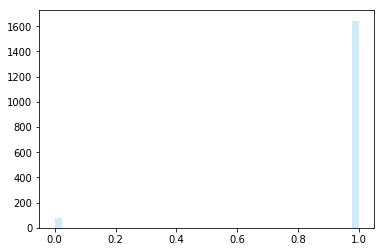

In [107]:
sns.distplot(worker_prediction, kde=False, color="skyblue")

In [108]:
#df_tw['prediction'] = worker_prediction

In [142]:
worker_answers = []
for idx, i in enumerate(worker_prediction):
    if i == 1:
        worker_answers.append(df_tw['true_answers'].loc[idx])
    else:
        worker_answers.append(np.random.choice([i for i in set(answers_key)-set(df_tw['true_answers'].loc[idx])], 1)[0])

In [144]:
df_tw['worker_answers'] = worker_answers

In [103]:
df_tw.head()

,task_id,worker_id,true_answers,label_task,prob_task,prob_worker,prob_answer
0,task_uEe,Xr9Wt,bands,easy_task,0.8,0.840759,0.954790
1,task_uEe,rmbe5,bands,easy_task,0.8,0.747545,0.922145
2,task_uEe,MBwiu,bands,easy_task,0.8,0.831361,0.951736
3,task_uEe,Lnhse,bands,easy_task,0.8,0.991955,0.997976
4,task_uEe,Hgs8g,bands,easy_task,0.8,0.968297,0.991881


---
### Confusion Matrix for the answers

In [148]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df_tw['true_answers'], df_tw['worker_answers'])

array([[324,   3,   2,   2,   4],
       [  1, 309,   5,   1,   4],
       [  3,   2, 362,   3,   5],
       [  7,   1,   5, 383,   4],
       [  3,   2,   1,   2, 282]])

In [156]:
import turicreate as tc
sf_tw = tc.SFrame(data=df_tw)
conf_matrix = tc.evaluation.confusion_matrix(sf_tw['true_answers'], sf_tw['worker_answers'])

In [158]:
conf_matrix.print_rows(25,)

+----------------+-----------------+-------+
|  target_label  | predicted_label | count |
+----------------+-----------------+-------+
|     score      |      bands      |   1   |
|     score      |  administrators |   7   |
|     bands      |  administrators |   1   |
|    sixties     |      score      |   2   |
| administrators |      bands      |   3   |
| administrators |      score      |   2   |
|     hoods      |      bands      |   2   |
|     score      |      hoods      |   5   |
|     score      |     sixties     |   4   |
|     score      |      score      |  383  |
|    sixties     |      bands      |   2   |
|    sixties     |     sixties     |  282  |
|     hoods      |  administrators |   3   |
|    sixties     |      hoods      |   1   |
| administrators |     sixties     |   4   |
|     hoods      |      score      |   3   |
|     bands      |      bands      |  309  |
|     bands      |      hoods      |   5   |
| administrators |      hoods      |   2   |
|     hood

In [163]:
accuracy = conf_matrix[conf_matrix['target_label'] == conf_matrix['predicted_label']]['count'].sum() / conf_matrix['count'].sum()

In [164]:
print(accuracy)

0.9651162790697675


Try the confusion matrix library to track all the different measures of the workers  
https://github.com/sepandhaghighi/pycm

---
### Measuring Performance

Next we measure the performance of the worker. The performance is calculate as the number of times a worker answers right (in comparison with the true answer) over the total number of workers per task.  

The range of the performance value spans from 0 to 1. The values close to 1 indicate that the majority of the workers had consensus. The values close to 0 indicate that there was no consensus.

In [165]:
df_tw['performance'] = worker_prediction

In [168]:
tasks_mean = df_tw.groupby('task_id').mean().sort_values('performance', ascending=False)

In [170]:
tasks_mean['performance'].head()

task_id
task_VbN    1.0
task_dBo    1.0
task_bvo    1.0
task_bdN    1.0
task_baB    1.0
Name: performance, dtype: float64

/Users/pedrohserrano/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


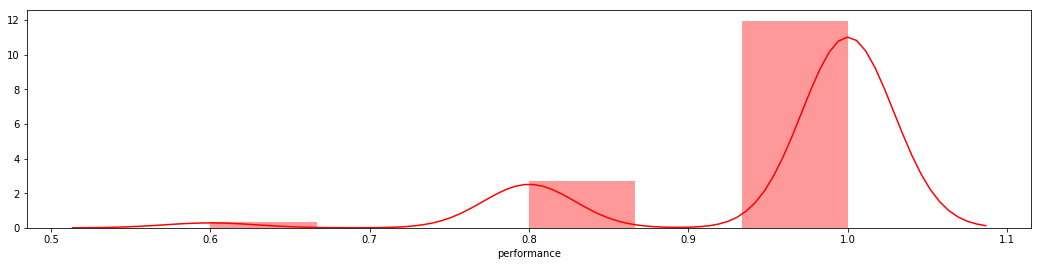

In [171]:
#Distribution of the performance
plt.figure(figsize=[18, 4])
sns.distplot(tasks_mean['performance'], bins=6, color='red')

In [176]:
workers_mean = df_tw.groupby('worker_id').mean().sort_values('performance', ascending=False)
df_workers = pd.merge(workers_mean.reset_index(), df_workers.drop('prob_worker',1), on='worker_id', how='left')

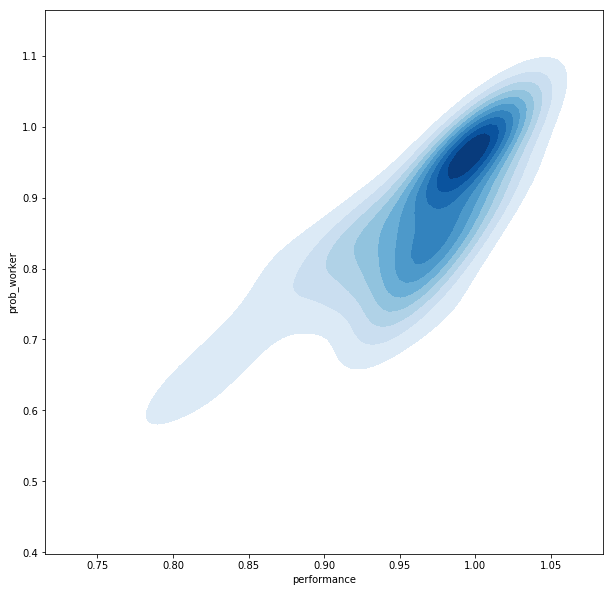

In [177]:
plt.figure(figsize=[10, 10])
sns.kdeplot(df_workers['performance'], df_workers['prob_worker'], cmap="Blues", shade=True, shade_lowest=False)

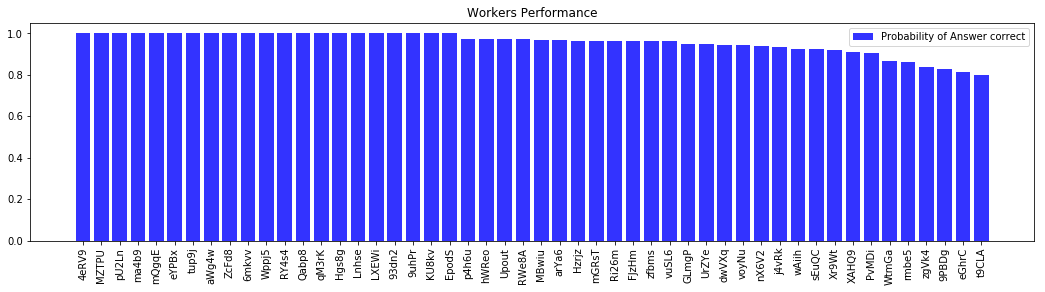

In [178]:
plt.figure(figsize=[18, 4])
axis = range(len(workers_mean))
plt.bar(axis, workers_mean['performance'], align='center', alpha=0.8, color='blue', label='Probability of Answer correct')
plt.xticks(axis, workers_mean.index, rotation=90)
plt.title('Workers Performance')
plt.legend(loc='best')
plt.show()

In [179]:
df_workers.describe()

,prob_task,prob_worker,prob_answer,prediction,performance
count,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.822869,0.855898,0.956411,0.957301,0.957301
std,0.017243,0.107422,0.036806,0.054136,0.054136
min,0.782581,0.565647,0.837622,0.800000,0.800000
25%,0.808661,0.806900,0.943871,0.941597,0.941597
50%,0.820645,0.848094,0.957281,0.971008,0.971008
75%,0.834342,0.954616,0.988095,1.000000,1.000000
max,0.872143,0.996468,0.999128,1.000000,1.000000


--- 
## Split the good workers from the rest  

Take all the workers whose performance was complete (1)

In [183]:
worker_label = []
for i in df_workers['performance']:
    if i == 1:
        worker_label.append('good_worker')
    else:
        worker_label.append('poor_worker')
        
df_workers['label_worker'] = worker_label

In [185]:
#df_workers

---
# Accuracy One Function

In [1]:
total_tasks = 342
total_workers = 50
p_hard_tasks = 0.2
n_hard_tasks = int(round(p_hard_tasks*total_tasks,0))
p_easy_tasks = 1-p_hard_tasks 
n_easy_tasks = int(round(p_easy_tasks*total_tasks,0))
print(n_hard_tasks, n_easy_tasks)

68 274


In [2]:
param_beta1 = 1
param_beta2 = 1

In [3]:
workers_per_task = 5

In [8]:
import sys
import pandas as pd
import numpy as np
import shortuuid as uid
from random_words import RandomWords
from scipy.stats import beta
from scipy.stats import bernoulli
from sklearn.metrics import confusion_matrix
import turicreate as tc

def get_accuracy(total_tasks, total_workers, p_hard_tasks, workers_per_task, param_beta1 = 1, param_beta2 = 1):
    workers = [uid.ShortUUID().random(length=5) for i in range(total_workers)]
    df_workers = pd.DataFrame()
    df_workers['worker_id'] = workers
    #### Tasks 
    tasks = ['task_'+uid.ShortUUID().random(length=3) for i in range(total_tasks)]
    easy_tasks = [task for task in np.random.choice(tasks, n_easy_tasks, replace=False)]
    hard_tasks = [task for task in set(tasks)-set(easy_tasks)]

    rw = RandomWords()
    answers_key = rw.random_words(count=5)
    true_answers = [answer for answer in np.random.choice(answers_key, total_tasks)]

    # Creating the tasks data frame
    df_tasks = pd.DataFrame()
    df_tasks['task_id'] = tasks
    df_tasks['true_answers'] = true_answers
    df_tasks['label_task'] = ['hard_task' if tasks[i] in hard_tasks else 'easy_task' for i in range(total_tasks)]

    data_beta = beta.rvs(param_beta1, param_beta2, size=total_workers)
    df_workers['prob_worker'] = data_beta #probs_workers

    # Threshold of responses
    cut_tasks = 0.75
    probs_tasks = []
    for i in df_tasks['label_task']:
        if i == 'easy_task':
            probs_tasks.append(np.random.choice((np.arange(cut_tasks, 1, 0.01)), 1)) #a random number form cut to 1
        elif i == 'hard_task':
            probs_tasks.append(np.random.choice((np.arange(0.5, cut_tasks, 0.01)), 1)) #a random number form chance to cut
        else: probs_tasks.append(1)

    probs_tasks = [item for prob in probs_tasks for item in prob]
    df_tasks['prob_task'] = probs_tasks

    list_tasks = [[tasks[i]]*workers_per_task for i in range(total_tasks)] #replicate the tasks to train 
    list_tasks = [item for sublist in list_tasks for item in sublist] #flat and clean list

    # Asign workers on every task 
    tasks_workers = [np.random.choice(workers, workers_per_task, replace=False) for task in tasks]
    tasks_workers = [worker for sublist in tasks_workers for worker in sublist] #flat and clean list

    df_tw = pd.DataFrame()
    df_tw['task_id'] = list_tasks
    df_tw['worker_id'] = tasks_workers
    df_tw = pd.merge(df_tw, df_tasks, on='task_id', how='left')
    df_tw = pd.merge(df_tw, df_workers, on='worker_id', how='left')

    prob_guess = 1 / len(answers_key)
    df_tw['prob_answer'] = (df_tw['prob_task'] * df_tw['prob_worker']) / (df_tw['prob_task'] * df_tw['prob_worker'] + prob_guess * (1-df_tw['prob_worker']))

    worker_prediction = [bernoulli.rvs(size=1,p=prob)[0] for prob in df_tw['prob_answer']]

    worker_answers = []
    for idx, i in enumerate(worker_prediction):
        if i == 1:
            worker_answers.append(df_tw['true_answers'].loc[idx])
        else:
            worker_answers.append(np.random.choice([i for i in set(answers_key)-set(df_tw['true_answers'].loc[idx])], 1)[0])

    df_tw['worker_answers'] = worker_answers


    confusion_matrix(df_tw['true_answers'], df_tw['worker_answers'])


    sf_tw = tc.SFrame(data=df_tw)
    conf_matrix = tc.evaluation.confusion_matrix(sf_tw['true_answers'], sf_tw['worker_answers'])
    accuracy = conf_matrix[conf_matrix['target_label'] == conf_matrix['predicted_label']]['count'].sum() / conf_matrix['count'].sum()
    
    return accuracy

In [12]:
get_accuracy(total_tasks, total_workers, p_hard_tasks, workers_per_task, param_beta1, param_beta2)

0.7895348837209303

In [32]:
vec_workers = [i+10 for i in range(100)] #[10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]

In [33]:
accu = [get_accuracy(total_tasks, i, p_hard_tasks, workers_per_task, param_beta1, param_beta2) for i in vec_workers]

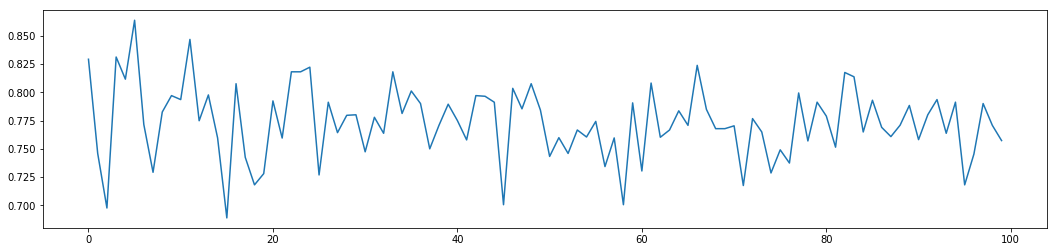

In [34]:
plt.figure(figsize=[18, 4])
plt.plot(range(len(vec_workers)), accu)